In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *


2024-01-23 11:54:41.171184: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Max mutual information vs sampling density for different samples

In [15]:
from scipy.signal import resample

N_objects = 5000
noise_sigma = 1e-3
num_samples_list = [1, 4, 9, 16, 25, 36]
num_bootstrap_samples = 1
upsampling_factor = 16
max_epochs = 5000
confidence = 90
num_nyquist_samples = 16
object_names = ['white_noise', 'delta_uniform', '8_deltas_uniform']

# Fro debugging
# object_names = ['delta_uniform',]
# max_epochs = 1000
# num_nyquist_samples = 16

# num_samples_list = [1, 4, 9, 16]

upsampled_signal_length = upsampling_factor*num_nyquist_samples
objects_fn_delta = lambda : np.array([generate_random_object('delta', num_deltas=1, object_size=upsampled_signal_length) for i in range(N_objects)])
objects_fn_8_delta = lambda : np.array([generate_random_object('delta', num_deltas=8, object_size=upsampled_signal_length) for i in range(N_objects)])
objects_fn_white_noise = lambda : np.array([generate_random_object('white_noise', object_size=upsampled_signal_length) for i in range(N_objects)])


mi_by_object = {}
mi_by_object_hi = {}
mi_by_object_lo = {}
for name in object_names:
  print(name)
  mutual_information = []
  mi_hi = []
  mi_lo = []

  if name == 'delta_uniform':
    objects_fn = objects_fn_delta
  elif name == '8_deltas_uniform':
    objects_fn = objects_fn_8_delta
  else:
    objects_fn = objects_fn_white_noise

  # Find an optimal PSF for this object
  initial_kernel, initial_params, optimized_params, objects, _, _ = optimize_PSF_and_estimate_mi(
      objects_fn, noise_sigma, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length,
      max_epochs=max_epochs, )

  # compute the information with this psf when integrating over pixels of different sizes 
  for num_samples in tqdm(num_samples_list):


    runs = []
    for i in range(num_bootstrap_samples):

      # do the estimation
      scale_factor = 1000 # because these signals are 0-1 but pixel cnn is designed for photon counts
      test_objects = objects_fn()
      output_signals = conv_forward_model(optimized_params, test_objects,
                                                  integrate_output_signals=False, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length)
      
      # interpolate to higher resolution before integrating
      resampled_signal_length = num_samples * upsampling_factor

      resampled_output_signals = resample(output_signals, resampled_signal_length, axis=-1)
      # normalize to sum to 1
      resampled_output_signals = resampled_output_signals / np.sum(resampled_output_signals, axis=-1, keepdims=True)
      pixelated_signal = integrate_pixels(resampled_output_signals, num_samples)

      # amount of noise to add to the pixel depends on its area
      relative_sampling_area = num_nyquist_samples / num_samples
      pixel_variance = noise_sigma**2 * relative_sampling_area

      noisy_pixelated_signals = pixelated_signal + jax.random.normal(jax.random.PRNGKey(onp.random.randint(10000)), pixelated_signal.shape) * np.sqrt(pixel_variance)

      fake_images = noisy_pixelated_signals.reshape(-1, int(np.sqrt(num_samples)), int(np.sqrt(num_samples))) * scale_factor
      mi_estimate = estimate_mutual_information(fake_images, gaussian_noise_sigma=float(np.sqrt(pixel_variance) * scale_factor), verbose=False, entropy_model='pixelcnn')                                                      
      print(mi_estimate)
      runs.append(mi_estimate)
    runs = np.array(runs)
    mutual_information.append(np.median(runs))
    mi_lo.append(np.percentile(np.array(runs), 100-confidence))
    mi_hi.append(np.percentile(np.array(runs), confidence))
  mi_by_object[name] = mutual_information
  mi_by_object_hi[name] = mi_hi
  mi_by_object_lo[name] = mi_lo

white_noise
initial loss -0.20848109544504848
computing optimized mi


 17%|█▋        | 1/6 [00:55<04:36, 55.28s/it]

0.006632493870844869


 33%|███▎      | 2/6 [02:02<04:09, 62.50s/it]

1.5366248936940297


 50%|█████     | 3/6 [02:54<02:52, 57.54s/it]

1.5967183577612045


 67%|██████▋   | 4/6 [03:42<01:47, 53.82s/it]

1.2773036025651223


 83%|████████▎ | 5/6 [04:42<00:55, 55.92s/it]

0.9334115275614744


100%|██████████| 6/6 [05:40<00:00, 56.72s/it]

0.7209773653577708
delta_uniform


initial loss -3.880581859625792
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.01% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 17%|█▋        | 1/6 [00:38<03:11, 38.23s/it]

0.09851112940658485


 33%|███▎      | 2/6 [01:20<02:42, 40.57s/it]

3.269507293279715


 50%|█████     | 3/6 [02:33<02:46, 55.35s/it]

1.9159931421983536


 67%|██████▋   | 4/6 [03:26<01:48, 54.30s/it]

0.972085648113594


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.68% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 83%|████████▎ | 5/6 [04:29<00:57, 57.68s/it]

0.948280975572422


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 2.27% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
100%|██████████| 6/6 [05:41<00:00, 56.86s/it]

0.7239875776958226
8_deltas_uniform


initial loss -2.9076369110528657
computing optimized mi


 17%|█▋        | 1/6 [00:35<02:55, 35.09s/it]

-0.01976099562646692


 33%|███▎      | 2/6 [01:15<02:32, 38.17s/it]

5.417616005976023


 50%|█████     | 3/6 [02:18<02:29, 49.70s/it]

5.136932038733974


 67%|██████▋   | 4/6 [03:08<01:39, 49.68s/it]

4.078317619968549


 83%|████████▎ | 5/6 [04:10<00:54, 54.22s/it]

2.8532947910139126


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.00% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
100%|██████████| 6/6 [05:05<00:00, 50.87s/it]

2.073305670194729


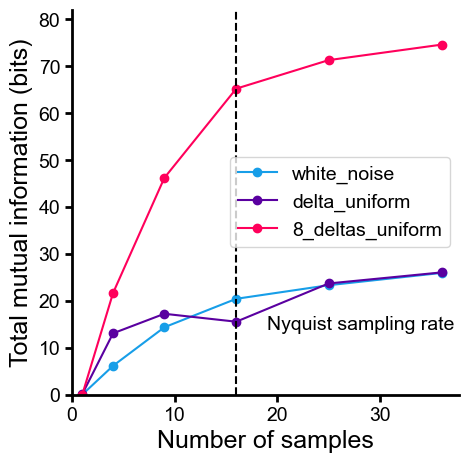

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for object_name, mutual_information in mi_by_object.items():
    total_mi = np.array(mutual_information) * np.array(num_samples_list)

    ax.plot(num_samples_list, total_mi, 'o-', label=object_name)
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Total mutual information (bits)')

    ax.set(ylim=(0, max(1.1 * np.max(total_mi), ax.get_ylim()[1])), xlim=(0, ax.get_xlim()[1]))

# plot a dashed line at the number of nyquist samples
ax.axvline(num_nyquist_samples, linestyle='--', color='k')
ax.text(num_nyquist_samples + 3, 0.2 * np.max(total_mi), 'Nyquist sampling rate', rotation=0, va='center')
clear_spines(ax)
ax.legend()

## (NON UPDATED) Show phase transition behavior with increasing Nyquist samples

In [ ]:
N_objects = 2000
num_bootstraps = 10
noise_sigma = 1e-3
num_samples = np.linspace(2, 96, 15).astype(int)
num_nyquist_samples_list = [8, 16, 24, 32, 48]



objects_fn = lambda : np.array([sample_amplitude_object('delta', num_deltas=1, gaussian_mixture_position=False) for i in range(N_objects)])

mi_vs_num_nyquist_samples = {}
for num_nyquist_samples in tqdm(num_nyquist_samples_list):

  mutual_information = []
  for N in tqdm(num_samples):
    erasure_mask = onp.zeros(OBJECT_LENGTH)
    sample_indices = onp.linspace(0, OBJECT_LENGTH - 1, N).astype(int)
    erasure_mask[sample_indices] = 1
    erasure_mask = np.array(erasure_mask, dtype=bool)
    mi_bootstraps = []
    for k in range(num_bootstraps):
      initial_kernel, initial_params, optimized_params, objects, initial_mi, optimized_mi = optimize_PSF_and_estimate_mi(
          objects_fn, noise_sigma, erasure_mask, num_nyquist_samples=num_nyquist_samples, nyquist_sample_output=False)
      mi_bootstraps.append(optimized_mi)

    mutual_information.append(onp.array(mi_bootstraps).max())
  mi_vs_num_nyquist_samples[num_nyquist_samples] = mutual_information


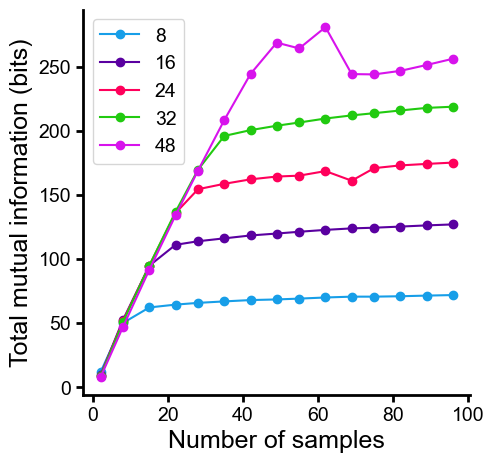

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for num_nyquist_samples, mutual_information in mi_vs_num_nyquist_samples.items():

    total_mi = np.array(mutual_information) * num_samples


    # ax.plot(num_samples, mutual_information, 'o-')
    ax.plot(num_samples, total_mi, 'o-', label=num_nyquist_samples)
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Total mutual information (bits)')

    # ax.set(ylim=(0, max(1.1 * np.max(total_mi), ax.get_ylim()[1])))

# plot a dashed line at the number of nyquist samples
# ax.axvline(num_nyquist_samples, linestyle='--', color='k')
# ax.text(num_nyquist_samples + 3, 0.2 * np.max(total_mi), 'Nyquist sampling rate', rotation=0, va='center')
clear_spines(ax)
ax.legend()

## Show transition behavior with different SNR levels

In [18]:
from scipy.signal import resample

N_objects = 5000
noise_sigma = 1e-3
num_samples_list = [1, 4, 9, 16, 25, 36]
num_bootstrap_samples = 1
upsampling_factor = 16
max_epochs = 5000
confidence = 90
num_nyquist_samples = 16
noise_sigmas_list = [1e-4, 1e-3, 1e-2, 1e-1]

# Fro debugging
# object_names = ['delta_uniform',]
# max_epochs = 1000
# num_nyquist_samples = 16

# num_samples_list = [1, 4, 9, 16]

upsampled_signal_length = upsampling_factor*num_nyquist_samples
objects_fn_delta = lambda : np.array([generate_random_object('delta', num_deltas=1, object_size=upsampled_signal_length) for i in range(N_objects)])
objects_fn_white_noise = lambda : np.array([generate_random_object('white_noise', object_size=upsampled_signal_length) for i in range(N_objects)])


mi_by_snr_median = {}
mi_by_snr_hi = {}
mi_by_snr_lo = {}
for noise_sigma in noise_sigmas_list:
  print('noise sigma', noise_sigma)
  mutual_information = []
  mi_hi = []
  mi_lo = []

  objects_fn = lambda : np.array([generate_random_object('delta', num_deltas=8, object_size=upsampled_signal_length) for i in range(N_objects)])


  # Find an optimal PSF for this object
  initial_kernel, initial_params, optimized_params, objects, _, _ = optimize_PSF_and_estimate_mi(
      objects_fn, noise_sigma, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length,
      max_epochs=max_epochs, )

  # compute the information with this psf when integrating over pixels of different sizes 
  for num_samples in tqdm(num_samples_list):


    runs = []
    for i in range(num_bootstrap_samples):

      # do the estimation
      scale_factor = 1000 # because these signals are 0-1 but pixel cnn is designed for photon counts
      test_objects = objects_fn()
      output_signals = conv_forward_model(optimized_params, test_objects,
                                                  integrate_output_signals=False, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length)
      
      # interpolate to higher resolution before integrating
      resampled_signal_length = num_samples * upsampling_factor

      resampled_output_signals = resample(output_signals, resampled_signal_length, axis=-1)
      # normalize to sum to 1
      resampled_output_signals = resampled_output_signals / np.sum(resampled_output_signals, axis=-1, keepdims=True)
      pixelated_signal = integrate_pixels(resampled_output_signals, num_samples)

      # amount of noise to add to the pixel depends on its area
      relative_sampling_area = num_nyquist_samples / num_samples
      pixel_variance = noise_sigma**2 * relative_sampling_area

      noisy_pixelated_signals = pixelated_signal + jax.random.normal(jax.random.PRNGKey(onp.random.randint(10000)), pixelated_signal.shape) * np.sqrt(pixel_variance)

      fake_images = noisy_pixelated_signals.reshape(-1, int(np.sqrt(num_samples)), int(np.sqrt(num_samples))) * scale_factor
      mi_estimate = estimate_mutual_information(fake_images, gaussian_noise_sigma=float(np.sqrt(pixel_variance) * scale_factor), verbose=False, entropy_model='pixelcnn')                                                      
      print(mi_estimate)
      runs.append(mi_estimate)
    runs = np.array(runs)
    mutual_information.append(np.median(runs))
    mi_lo.append(np.percentile(np.array(runs), 100-confidence))
    mi_hi.append(np.percentile(np.array(runs), confidence))
  mi_by_snr_median[name] = mutual_information
  mi_by_snr_hi[name] = mi_hi
  mi_by_snr_lo[name] = mi_lo

8_deltas_uniform
initial loss -5.958702220442502
computing optimized mi


 17%|█▋        | 1/6 [00:40<03:24, 40.98s/it]

0.2879641617698609


 33%|███▎      | 2/6 [01:54<03:59, 59.99s/it]

8.866083431923412


 50%|█████     | 3/6 [03:04<03:13, 64.67s/it]

8.183762188746014


 67%|██████▋   | 4/6 [04:18<02:16, 68.26s/it]

7.40617774044947


 83%|████████▎ | 5/6 [05:40<01:13, 73.33s/it]

5.767965904866333


100%|██████████| 6/6 [07:03<00:00, 70.60s/it]

4.744670864079724
8_deltas_uniform


initial loss -2.7518719760454684
computing optimized mi


 17%|█▋        | 1/6 [00:42<03:32, 42.50s/it]

-0.057191299760248594


 33%|███▎      | 2/6 [01:32<03:08, 47.00s/it]

5.111142234207895


 50%|█████     | 3/6 [02:37<02:45, 55.02s/it]

5.458423335575443


 67%|██████▋   | 4/6 [03:33<01:50, 55.46s/it]

4.053750930188701


 83%|████████▎ | 5/6 [04:40<00:59, 59.75s/it]

2.8607815397712724


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.00% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
100%|██████████| 6/6 [05:41<00:00, 56.96s/it]

2.0453034549812465
8_deltas_uniform


initial loss -0.46341310483498577
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 2.56% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 17%|█▋        | 1/6 [00:41<03:27, 41.40s/it]

0.04932276152941902


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.12% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 33%|███▎      | 2/6 [01:31<03:05, 46.39s/it]

2.0785790769808288


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.99% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 50%|█████     | 3/6 [02:45<02:56, 58.96s/it]

2.1535579834454817


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 2.62% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 67%|██████▋   | 4/6 [03:44<01:57, 58.91s/it]

1.6444927996634542


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 4.37% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 83%|████████▎ | 5/6 [04:41<00:58, 58.38s/it]

1.134434183083876


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 5.94% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
100%|██████████| 6/6 [05:34<00:00, 55.76s/it]

0.8152918373084848
8_deltas_uniform


initial loss -0.007676091835138022
computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 29.07% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
  0%|          | 0/6 [00:00<?, ?it/s]/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 0.74% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 17%|█▋        | 1/6 [00:42<03:34, 42.86s/it]

-0.03988872092593683


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 14.21% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 33%|███▎      | 2/6 [02:58<06:28, 97.15s/it]

0.23055881032221873


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 23.92% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 50%|█████     | 3/6 [04:10<04:17, 85.89s/it]

0.18828476094283148


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 28.69% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 67%|██████▋   | 4/6 [05:18<02:37, 78.98s/it]

0.13302607040887787


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 32.16% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
 83%|████████▎ | 5/6 [06:39<01:19, 79.49s/it]

0.09190222897786837


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:226: UserWarning: 34.86% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
100%|██████████| 6/6 [07:57<00:00, 79.55s/it]

0.06383948789187487


[Text(0.5, 1.0, 'SNR comparison')]

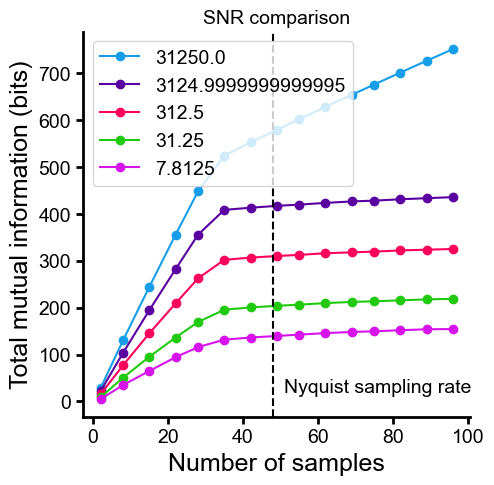

In [7]:
snrs = (1 / NUM_NYQUIST_SAMPLES) / np.array(noise_sigma_list)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for (noise_sigma, mutual_information), snr in zip(mi_vs_num_samples_by_noise.items(), snrs):

    total_mi = np.array(mutual_information) * num_samples

    # ax.plot(num_samples, mutual_information, 'o-')
    ax.plot(num_samples, total_mi, 'o-', label=snr)
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Total mutual information (bits)')

    # ax.set(ylim=(0, max(1.1 * np.max(total_mi), ax.get_ylim()[1])))

# plot a dashed line at the number of nyquist samples
ax.axvline(NUM_NYQUIST_SAMPLES, linestyle='--', color='k')
ax.text(NUM_NYQUIST_SAMPLES + 3, 0.2 * np.max(total_mi), 'Nyquist sampling rate', rotation=0, va='center')
clear_spines(ax)
ax.legend()
ax.set(title='SNR comparison')